In [50]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers

In [2]:
# setting the working folder to the following path
data_path = '..\\data'
os.chdir(r'..\\data')

os.listdir() # function that returns files in a folder

['Patient 383',
 'Patient 384',
 'Patient 410',
 'Patient 416',
 'Patient 430',
 'Patient 513',
 'Patient 531',
 'Patient 634',
 'Patient 836']

I am in the folder Patient 383
I am in the folder Patient 384
I am in the folder Patient 410
Dimensions target images up to 384 and 308 voxels
0 448
1 448
2 384


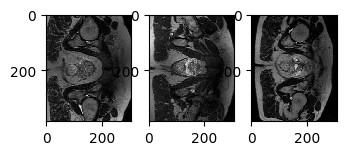

In [3]:
#empty lists to fill with data:
dce = []
t2 = []
adc = []
dwi = []
mask_prost = []
mask_guz = []
for patient in os.listdir(data_path)[0:3]:
    print("I am in the folder %s"%patient)
    for image in os.listdir(data_path+'/'+patient):
        # print("Patient files %s:"%patient, image)
        if 'adc' in image and 'resampled' in image:
            adc.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        elif 'epi' in image and 'resampled' in image:
            dwi_temp = np.squeeze(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
            dwi.append(dwi_temp)
        elif 't2' in image:
            t2.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        elif 't1' in image and 'resampled' in image:
            dce_temp = np.squeeze(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
            elem1 = np.max(dce_temp, 3)
            elem2 = np.argmax(dce_temp, 3)
            new_dce = np.stack((elem1, elem2),-1)
            dce.append(new_dce)
        elif 'cap' in image:
            mask_guz.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        elif 'prostate_mask' in image:
            mask_prost.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        else:
            print("Unexpected file!",image)

# It is necessary to crop images, due to the different sizes of T2-dependent images
# we assume that the images have the same spatial resolution (e.g., 1mmx1mmx1mm)
# In the case of different resolutions, interpolation should be made so that each patient
# had the same resolution of images.

rows = []
cols = []
for patient in t2:
  rows.append(patient.shape[0])
  cols.append(patient.shape[1])

scol = min(cols)
srow = min(rows)
print("Dimensions target images up to %d and %d voxels"%(min(rows), min(cols)))
# Target dimensions of images up to 384 x 308 voxels

for i, patient in enumerate(t2):
    print (i, patient.shape[0])
    col_slice = slice (0, None)
    row_slice = slice (0, None)

    row = patient.shape[0]
    col = patient.shape[1]
    do_cut_row = row-srow
    do_cut_col = col-scol
    if do_cut_col > 0 and do_cut_col% 2 == 0:
        col_slice = slice (do_cut_col//2,-do_cut_col//2)
    elif do_cut_col > 0 and do_cut_col% 2 == 1:
        col_slice = slice (do_cut_col // 2 + 1, -do_cut_col // 2)

    if do_cut_row > 0 and do_cut_row% 2 == 0:
        row_slice = slice (do_cut_row // 2, -do_cut_row // 2)
    elif do_cut_row > 0 and do_cut_row% 2 == 1:
        row_slice = slice (do_cut_row // 2 + 1,-do_cut_row // 2)

    patient_crop = patient [row_slice, col_slice, ...]
    t2[i] = patient_crop

    adc[i] = adc[i][row_slice, col_slice,...]
    dce[i] = dce[i][row_slice, col_slice,...]
    dwi[i] = dwi[i][row_slice, col_slice,...]

    # Cropping des masques
    if mask_guz is not None:
        mask_guz[i] = mask_guz[i][row_slice, col_slice,...]

    if mask_prost is not None:
        mask_prost[i] = mask_prost[i][row_slice, col_slice,...]


# we check the result
plt.figure()
for i,image in enumerate(t2):
    plt.subplot(2,5,i+1)
    plt.imshow(image[:,:, 32], cmap = 'gray', interpolation = 'none', vmin = 0)


In [4]:
t2 = np.array(t2, dtype=np.int64)
adc = np.array(adc, dtype=np.int64)
dce = np.array(dce, dtype=np.int64)
dwi = np.array(dwi, dtype=np.int64)
mask_guz = np.array(mask_guz, dtype=np.int64)
mask_prost = np.array(mask_prost, dtype=np.int64)

In [5]:
t2 = t2.reshape((3, 384, 308, 64, 1))
adc = adc.reshape((3, 384, 308, 64, 1))
mask_guz = mask_guz.reshape((3, 384, 308, 64, 1))
mask_prost = mask_prost.reshape((3, 384, 308, 64, 1))

print(t2.shape)
print(adc.shape)
print(dce.shape)
print(dwi.shape)
print(mask_guz.shape)
print(mask_prost.shape)

(3, 384, 308, 64, 1)
(3, 384, 308, 64, 1)
(3, 384, 308, 64, 2)
(3, 384, 308, 64, 6)
(3, 384, 308, 64, 1)
(3, 384, 308, 64, 1)


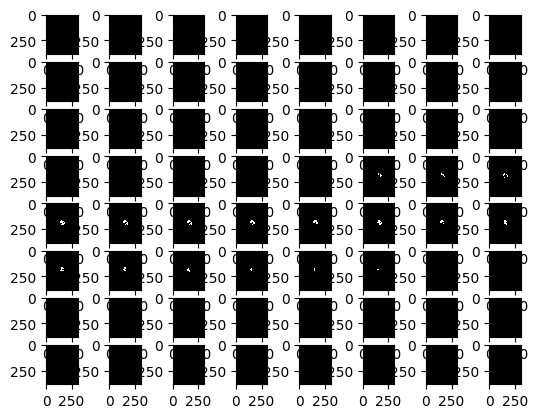

In [41]:
plt.figure()
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(mask_guz[2,:,:,i], cmap = 'gray', interpolation = 'none', vmin = 0)

In [6]:
data = np.concatenate((t2, adc, dce, dwi), axis=4)
data = np.concatenate([data[i] for i in range(data.shape[0])], axis=2)
data = np.moveaxis(data, 2, 0)
del t2
del adc
del dce
del dwi

In [12]:
data.shape

(192, 384, 308, 10)

In [48]:
from sklearn.model_selection import train_test_split

mask = np.concatenate([mask_guz[i] for i in range(mask_guz.shape[0])], axis=2)
mask = np.moveaxis(mask, 2, 0)
print(mask.shape)

X = data
y = mask

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

(192, 384, 308, 1)


In [58]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(2, (3,3), activation="softmax", padding="same")(x)
    outputs = layers.Cropping2D(((0, 0), (0, 4)))(outputs)
    print(inputs.shape, outputs.shape)
    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(X.shape[1:], 2)
model.summary()

(None, 384, 308, 10) (None, 384, 308, 2)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 384, 308,  │          0 │ -                 │
│ (InputLayer)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 192, 154,  │      2,912 │ input_layer_14[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 154,  │        128 │ conv2d_90[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_61       │ (None, 192, 154,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_62       │ (None, 192, 154,  │          0 │ activation_61[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_24 │ (None, 192, 154,  │      2,400 │ activation_62[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 154,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_63       │ (None, 192, 154,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_25 │ (None, 192, 154,  │      4,736 │ activation_63[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 154,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 96, 77,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 96, 77,    │      2,112 │ activation_61[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 96, 77,    │          0 │ max_pooling2d_27… │
│                     │ 64)               │            │ conv2d_91[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 96, 77,    │          0 │ add_27[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_26 │ (None, 96, 77,    │      8,896 │ activation_64[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 77,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 96, 77,    │          0 │ batch_normalizat

 Total params: 511,522 (1.95 MB)

 Trainable params: 509,794 (1.94 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [59]:
model = get_model(data.shape[1:4], 2)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['precision'])

(None, 384, 308, 10) (None, 384, 308, 2)


In [60]:
model.fit(x=X_train, y=y_train, batch_size=16, epochs=100)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1986, in _run_once

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\blanc\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\blanc\AppData\Local\Temp\ipykernel_2500\212756747.py", line 1, in <module>

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 371, in fit

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 219, in function

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 132, in multi_step_on_iterator

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 113, in one_step_on_data

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 84, in train_step

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 490, in compute_metrics

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 334, in update_state

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 21, in update_state

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\metrics\confusion_metrics.py", line 378, in update_state

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 592, in update_confusion_matrix_variables

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 565, in weighted_assign_add

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\numpy.py", line 3617, in logical_and

  File "c:\Users\blanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1520, in logical_and

Incompatible shapes: [1,3784704] vs. [1,1892352]
	 [[{{node LogicalAnd_1}}]] [Op:__inference_multi_step_on_iterator_20012]